# ME 696 Introduction to Autonomous Mobile Robots - Fall 2020
## Exam 1 - Due Sunday, Nov 8, 2020
----
#### In this exam, we will implement a state estimator for a mobile robot operating in a 2D world using both the extended Kalman filter and the particle filter. You should submit a single PDF that contains all your answers, steps, codes (with comments), and plots (with sufficient and clear annotations).  You can use either MATLAB or Python for your simulation.

----
The robot's motion can be modeled as follows

$$ \begin{bmatrix} x_{k+1} \\ y_{k+1} \\ \theta_{k+1} \end{bmatrix} = \begin{bmatrix} x_{k} + v\cos(\theta)\Delta t \\ y_{k} + v\sin(\theta) \Delta t \\ \theta_{t} + \omega \Delta t \end{bmatrix}, $$  
where $v$ is the forward speed and $\omega$ is the angular velocity. The robot is equipted with a sensor that can measure the relative range, $d$, with respect to a known landmark located at the origin, i.e., $[m_x, m_y]^\top = [0, 0]^\top$. 

Assume that we know the following:  
1. The initial state estimate and its covariance matrix are  

$$ \boldsymbol{\mu}_0 = \begin{bmatrix} 10\cos(\pi/24)\\ 10\sin(\pi/24)\\ \pi/2 \end{bmatrix}, \quad \Sigma_0 = \begin{bmatrix} 1 & 0 & 0\\ 0 & 4 & 0 \\ 0 & 0 & 0.25 \end{bmatrix}. $$  

2. The robot has a sensor to provide noisy measurements at 1Hz ($\Delta t = 1s$) of its forward speed that follows a Gaussian distribution $v\sim \mathcal{N}(2.5, 1^2)$ and its angular velocity that also follows a Gaussian distribution $\omega\sim \mathcal{N}(\frac{\pi}{12}, 0.1^2)$. 
3. The relative range measurements with respect to the known landmark are available at 0.1Hz (every 10 seconds) and follow a Gaussian distribution $d\sim \mathcal{N}(10, 1^2)$.

----
### Questions

1. Design and implement an extended Kalman filter (EKF) to estimate the states of the robots with the following steps:  
    `[10 points]` 1.1. Derive the linearized motion model and show detailed steps of how you obtained the Jacobian matrices $A$, $B$, and motion noise covariance $Q$.  
    `[10 points]` 1.2. Derive the nonlinear motion model for $d$ and linearized it to obtain the Jacobian matrix $H$ and the measurement noise covariance $R$.   
    `[15 points]` 1.3. Implement the EKF in your program of choise. For $t=[0, 100]$, plot the estimated states along with their 1-$\sigma$ bounds. You should have three separate plots, one for each state. 
2. Assume that we do not know the location of the landmark and want to solve this SLAM problem:  
    `[ 5 points]` 2.1. Define the new state vector for this SLAM problem.   
    `[10 points]` 2.2. Derive the motion model and its linearization.   
    `[10 points]` 2.3. Derive the measurement model and its linearizaiton.   
    `[Bonus 10 points]` 2.4. Implement an EKF to solve this SLAM problem and discuss your finding. 

3. Now let's go back to the cased where the landmark location is known. Design and implement a particle filter with 1000 particles to estimate teh states of the robots with the following steps:  
    `[10 points]` 3.1. Generate particles for the initial state estimate, show particle set project on to the $x$-$y$ plane, and draw the 1-$\sigma$ sample ellipse.   
    `[10 points]` 3.2. Plot the sample distribution and the 1-$\sigma$ sample ellipse on the $x$-$y$ plane at $t=5$.  
    `[15 points]` 3.3. Implement the particle filter where resampling happens everytime a range measurement is available (i.e., every 10 seconds). Plot the sample distribution and the 1-$\sigma$ sample ellipse on the $x$-$y$ plane at $t=0$ both before and after the update step.  
    `[ 5 points]` 3.4. For $t=[0, 100]$, use Gaussian approxiamtions of the particle set to plot the estimated states along with their 1-$\sigma$ bounds. You should have three separate plots, one for each state. 
    
#### `Note`: You should make sure that your heading angle is always in between $[0, 2\pi]$.

#### `[10 points]` 1.1. Derive the linearized motion model and show detailed steps of how you obtained the Jacobian matrices $A$, $B$, and motion noise covariance $Q$.  

The motion model is defined as a function $\boldsymbol{\mu}_k=f(\boldsymbol{\mu}_{k-1}, \boldsymbol{u}_k)$. The initial state vector and the initial covariance matrix with the landmarks included is: 

$$ 
\boldsymbol{\mu}_0 = \begin{bmatrix} 
                            10\cos(\pi/24)\\ 
                            10\sin(\pi/24)\\ 
                            \pi/2 \\ 
                            m_x \\ 
                            m_y 
                        \end{bmatrix}, \quad 
\boldsymbol{\Sigma}_0 = \begin{bmatrix} 
                               1 & 0 & 0 & 0 & 0 \\ 
                               0 & 4 & 0 & 0 & 0 \\ 
                               0 & 0 & 0.25 & 0 & 0 \\
                               0 & 0 & 0 & \infty & 0 \\
                               0 & 0 & 0 & 0 & \infty 
                           \end{bmatrix} 
$$

To get the model in the form of $\boldsymbol{\mu}_k = A\boldsymbol{\mu}_{k-1} + B\boldsymbol{u}_k$, it must satisfy

$$
\begin{bmatrix}
    x_{k} \\ 
    y_{k} \\ 
    \theta_{k} \\
    m_x \\
    m_y
\end{bmatrix} =
\underbrace{\begin{bmatrix}
                x_{k-1} \\ 
                y_{k-1} \\ 
                \theta_{k-1} \\
                m_x \\
                m_y
            \end{bmatrix}}_{\text{A$\boldsymbol{\mu}_{k}$}} + 
\underbrace{\begin{bmatrix} 
                v\cos(\theta)\Delta t \\ 
                v\sin(\theta) \Delta t \\ 
                \omega \Delta t \\
                0 \\
                0
            \end{bmatrix}}_{\text{B$\boldsymbol{u}_{k}$}}
$$

We first look at what the system matrix $A$ is:
$$
\begin{bmatrix}
    x_{k-1} \\ 
    y_{k-1} \\ 
    \theta_{k-1} \\
    m_x \\
    m_y
\end{bmatrix} =
\underbrace{\begin{bmatrix}
                1 & 0 & 0 & 0 & 0 \\
                0 & 1 & 0 & 0 & 0 \\
                0 & 0 & 1 & 0 & 0 \\ 
                0 & 0 & 0 & 1 & 0 \\
                0 & 0 & 0 & 0 & 1
            \end{bmatrix}}_{\text{A}} 
\begin{bmatrix}
    x_{k-1} \\ 
    y_{k-1} \\ 
    \theta_{k-1} \\
    m_x \\
    m_y
\end{bmatrix}
$$

The control matrix $B$ is a matrix to transform the control vector $\boldsymbol{u}_k$ from a 3x1 vector into a 5x1 vector (in order to match the dimensions of the state vector). <br> <br>

$$
\begin{bmatrix} 
    v\cos(\theta)\Delta t \\ 
    v\sin(\theta)\Delta t \\ 
    \omega \Delta t \\
    0 \\
    0
\end{bmatrix} =
\underbrace{\begin{bmatrix}
                1 & 0 & 0 \\
                0 & 1 & 0 \\
                0 & 0 & 1 \\
                0 & 0 & 0 \\ 
                0 & 0 & 0 
            \end{bmatrix}}_{B} 
\underbrace{\begin{bmatrix}
                v\cos(\theta)\Delta t \\ 
                v\sin(\theta) \Delta t \\ 
                \omega \Delta t 
            \end{bmatrix}}_{u_k}                
$$


Since $v\sim \mathcal{N}(2.5, 1^2)$ and $\omega\sim \mathcal{N}(\frac{\pi}{12}, 0.1^2)$, the noise covariance $Q$ would be the covariance of the control vector. The covariance of the control vector is: <br> <br>
$$
\begin{align*}
Cov[\boldsymbol{u}] &= E[\boldsymbol{u}]E[\boldsymbol{u}]^\top \\ \\
                    &= E\begin{pmatrix} \begin{bmatrix} v \\ \omega \\ 0 \\ 0 \\ 0 \end{bmatrix} \end{pmatrix}
                       E\begin{pmatrix}\begin{bmatrix} v & \omega & 0 & 0 & 0 \end{bmatrix} \end{pmatrix} \\ \\
                    &= \begin{bmatrix} 2.5 \\ \frac{\pi}{12} \\ 0 \\ 0 \\ 0 \end{bmatrix}
                       \begin{bmatrix} 2.5 & \frac{\pi}{12} & 0 & 0 & 0 \end{bmatrix} \\ \\
                    &= \begin{bmatrix} 6.25 & \frac{2.5\pi}{12} & 0 & 0 & 0 \\
                                       \frac{2.5\pi}{12} & \frac{\pi^2}{144} & 0 & 0 & 0 \\ \\
                                       0 & 0 & 0 & 0 & 0 \\
                                       0 & 0 & 0 & 0 & 0 \\
                                       0 & 0 & 0 & 0 & 0
                       \end{bmatrix} \\ \\
                    &= Q
\end{align*}
$$

The Jacobian matrix will take the form:
$$
F_{k} = \begin{pmatrix} F_{\mu}^{3 x 3} & 0^{3 x 2N} \\ 0^{2N x 3} & I^{2N x 2N} \end{pmatrix}
$$

where $F_{\mu}$ is the Jacobian of the motion model (excluding the landmarks) and $I$ is the identity matrix of size 2N. The Jacobian of the motion model is: <br> <br>
$$
\begin{align*}
    F_{\mu} &= \frac{\delta}{\delta(x, y, \theta)}\begin{bmatrix}
                                                        \begin{pmatrix} x \\ y \\ \theta \end{pmatrix} + 
                                                        \begin{pmatrix} 
                                                            v\cos(\theta) \\ 
                                                            v\sin(\theta) \\ 
                                                            \omega 
                                                            \end{pmatrix}
                                                        \end{bmatrix} \\ \\
            &= I + \frac{\delta}{\delta(x, y, \theta)}\begin{bmatrix}
                                                        \begin{pmatrix} 
                                                            v\cos(\theta) \\ 
                                                            v\sin(\theta)  \\ 
                                                            \omega 
                                                        \end{pmatrix}
                                                      \end{bmatrix} \\  \\
            &= I + \begin{bmatrix} 0 & 0 & -v\sin(\theta) \\ 0 & 0 & v\cos{\theta} \\ 0 & 0 & 0 \end{bmatrix} \\ \\
            &= \begin{bmatrix} 1 & 0 & -v\sin(\theta) \\ 0 & 1 & v\cos{\theta} \\ 0  & 0 & 1 \end{bmatrix}
\end{align*}
$$

#### `[10 points]` 1.2. Derive the nonlinear motion model for $d$ and linearized it to obtain the Jacobian matrix $H$ and the measurement noise covariance $R$.   

The distance $d$ can be determined by finding the difference between the known x and y coordinates of the landmark and the robot's current estimated position: <br> <br>
$$
d = \begin{pmatrix} d_x \\ d_y \end{pmatrix} = \begin{pmatrix} m_x - x_k \\ m_y - y_k \end{pmatrix}
$$

The Euclidean distance can be found as: <br> <br>
$$
\begin{align*}
q &= \underbrace{d^\top d}_{\text{inner product}} = d_{x}^{2} + d_{y}^{2}
\end{align*}
$$

Using the Euclidean distance and the measured distance, the measurement model $\boldsymbol{\hat{z}}_{k}$ is: <br> <br>
$$
\boldsymbol{\hat{z}}_{k} = \begin{pmatrix} \sqrt{q} \\ \arctan2(d_y, d_x) - \mu_{k, \theta} \end{pmatrix} = 
                     h(\boldsymbol{\mu}_{k})
$$

The Observation Jacobian $H$ can be found by taking the partial derivative of the measurement model with respect to the current state estimate: <br> <br>
$$
\begin{align*}
H_{k} &= \frac{\delta h(\boldsymbol{\mu}_k)}{\delta \boldsymbol{\mu}_k} \\ \\
      &= \frac{\delta}{\delta(x_k, y_k, \theta_k, m_{x}, m_{y})}\begin{pmatrix} \sqrt{q} \\
         \arctan2(d_y, d_x) - \theta_k \end{pmatrix} \\ \\
      &= \begin{bmatrix} \frac{\delta \sqrt{q}}{\delta{x_k}} & 
                         \frac{\delta \sqrt{q}}{\delta{y_k}} &
                         \frac{\delta \sqrt{q}}{\delta{\theta_k}} &
                         \frac{\delta \sqrt{q}}{m_x} &
                         \frac{\delta \sqrt{q}}{m_y} \\
                         \frac{\delta arctan2(d_y, d_x) - \theta_k}{\delta{x_k}} &
                         \frac{\delta arctan2(d_y, d_x) - \theta_k}{\delta{y_k}} &
                         \frac{\delta arctan2(d_y, d_x) - \theta_k}{\delta{\theta_k}} &
                         \frac{\delta arctan2(d_y, d_x) - \theta_k}{\delta{m_x}} &
                         \frac{\delta arctan2(d_y, d_x) - \theta_k}{\delta{m_y}}
         \end{bmatrix} \\ \\
      &= \begin{bmatrix} \frac{1}{q}(-\sqrt{q}d_x) & 
                         \frac{1}{q}(-\sqrt{q}d_y) &
                         0 &
                         \frac{1}{q}(\sqrt{q}d_x) &
                         \frac{1}{q}(\sqrt{q}d_y) \\
                         \frac{d_y}{q} &
                         \frac{-d_x}{q} &
                         -1 &
                         -\frac{d_y}{q} &
                         \frac{d_x}{q}
         \end{bmatrix} \\ \\
      &= \frac{1}{q} \begin{bmatrix} -\sqrt{q}d_x & 
                         -\sqrt{q}d_y &
                         0 &
                         \sqrt{q}d_x &
                         \sqrt{q}d_y \\
                         d_y &
                         -d_x &
                         -q &
                         d_y &
                         d_x
                     \end{bmatrix}    
\end{align*}
$$

The noise covariance $R$ is the variance of the observation sensor $R = (\sigma = 1)^2$.  

#### `[15 points]` 1.3. Implement the EKF in your program of choise. For $t=[0, 100]$, plot the estimated states along with their 1-$\sigma$ bounds. You should have three separate plots, one for each state. 

Text(0, 0.5, 'Theta [radians]')

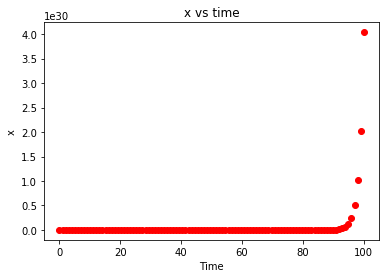

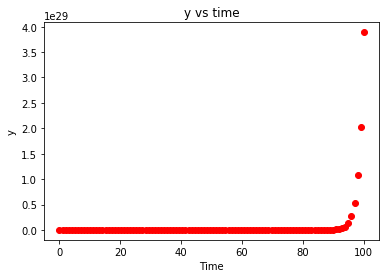

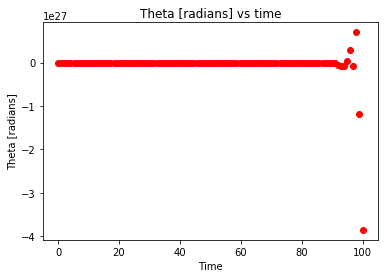

In [506]:
# Import libraries
from numpy.linalg import inv
import numpy as np
import math 
import matplotlib.pyplot as plt 

# Initialize initial state, covariance, and landmark
lmx = 0
lmy = 0
mu0 = np.array([[10*np.cos(np.pi/24)], [10*np.sin(np.pi/24)], [np.pi/2], [lmx], [lmy]])
sigma0 = np.array([[1, 0, 0, 0, 0], [0, 4, 0, 0, 0], [0, 0 , 0.25, 0, 0], [0, 0, 0, 10000, 0], [0, 0 ,0 , 0, 10000]])

# Initialize state and control matrices A and B, time, and noise covariance Q 
A = np.eye(5)
B = np.eye(5, 3)
pred = np.tile(mu0, (1, 100))
sigma = np.tile(sigma0, (100, 1, 1))
Q = np.array([[6.25, 2.5*np.pi/12, 0, 0, 0],
              [2.5*np.pi/12, np.pi*np.pi/144, 0, 0 ,0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0]])
R = 1

# Initialize noise parameters and initial control vector
mu_v = 2.5
mu_w = np.pi/12
mu_z = 10
sigma_v = 1
sigma_w = 0.1
sigma_z = 1
v = sigma_v * np.random.randn() + mu_v
w = sigma_w * np.random.randn() + mu_w
z = 0
u0 = np.array([v*np.cos(mu0[2]), v*np.sin(mu0[2]), w])

# EKF Algorithm 
for t in range(99):
    # Randomly generate a velocity and angular velocities based on their Gaussian distributions
    v = sigma_v * np.random.randn() + mu_v
    w = sigma_w * np.random.randn() + mu_w
    
    # Calculate the control vector u, Jacobian matrix F, and observation Jacobian H
    u = np.array([v*np.cos(pred[2,t]), v*np.sin(pred[2,t]), w])
    F = np.array([[1, 0, -v * np.sin(pred[2,t]), 0, 0],
                  [0, 1, v * np.cos(pred[2,t]), 0, 0],
                  [0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0]])
    d = np.array([[lmx - pred[0, t]], [lmy - pred[1, t]]])
    q = d[0]*d[0] + d[1]*d[1]
    z_hat = np.array([math.sqrt(q), np.arctan2(d[1], d[0]) - pred[2,t]])
    lowH = 1/q * np.array([[-math.sqrt(q) * pred[0, t], 
                            -math.sqrt(q) * pred[1, t], 
                            0, 
                            math.sqrt(q) * pred[0, t],
                            math.sqrt(q) * pred[1, t]],
                           [pred[1, t], -pred[0, t], -q, -pred[1,t], -pred[0,t]]])
    H = lowH @ np.eye(5)
    
    # Estimate the next state
    if t == 0: 
        pred[:,t+1] = A @ pred[:,t] + B @ u0
    else:
        pred[:,t+1] = A @ pred[:,t] + B @ u
    
    # Check to make sure the angle is not greater than 2*pi
    if pred[2,t+1] > (2*np.pi):
        pred[2,t+1] -= (2*np.pi)
    elif pred[2, t+1] < -(2*np.pi):
        pred[2, t+1] += (2*np.pi)
    
    # Estimate the next covariance
    if t == 0:
        sigma[0] = sigma[0]
    else:
        sigma[t+1] = F @ sigma[t] @ F.transpose() + Q 
    
    # Find the Kalman gain
    K = sigma[t+1] @ H.transpose() @ inv((H @ sigma[t+1] @ H.transpose()).astype(float) + R)
    
    # If there is a new measurement, update the measurement z
    if t % 10 == 0:
        z = sigma_z * np.random.randn() + mu_z
    
    # Correct the estimates
    pred[:, t+1] = pred[:, t+1] + K @ (z - z_hat)
    sigma[t+1] = (np.eye(5) - K @ H) @ sigma[t+1]
    
    # Check to make sure the angle is not greater than 2*pi again
    if pred[2,t+1] > (2*np.pi):
        pred[2,t+1] = pred[2, t+1] - (2*np.pi)
    elif pred[2, t+1] < -(2*np.pi): 
        pred[2, t+1] = pred[2, t+1] + (2*np.pi)

# Plot the robot's state (x, y, theta) vs time
t = np.linspace(0, 100, 100)

fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.scatter(t, pred[0], color='r')
ax1.set_title("x vs time")
ax1.set_xlabel('Time')
ax1.set_ylabel('x')

fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.scatter(t, pred[1], color='r')
ax2.set_title("y vs time")
ax2.set_xlabel('Time')
ax2.set_ylabel('y')

fig3 = plt.figure()
ax3 = fig3.add_subplot()
ax3.scatter(t, pred[2], color='r')
ax3.set_title("Theta [radians] vs time")
ax3.set_xlabel('Time')
ax3.set_ylabel('Theta [radians]')